# Novel predictions

Here, we ran our method on our all corpus of PubMed abstracts up to December 2020. We considered all clinical trials up to 2020 and also clinical trials that have been verified in 2021. We then constructed the positive training set using all PK-cancer pairs from clinical trials of phase IV. The negative training set contains randomly generated pairs of PKs and cancers where there was no evidence of treating the cancers by inhibiting the PK in the clinical trials data. Similar to the historical prediction analysis, we chose the size of the negative training set to be 10 times the size of the positive training set. The prediction set includes all possible PK-cancer pairs except those where there was evidence of treating the PKs in any of phase I, II, III or IV clinical trials that have been published so far. The prediction set also contains PK-cancer pairs for PKs that have not been targeted yet. 

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, precision_recall_curve,precision_score, recall_score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import pickle5 as pickle
sys.path.insert(0, os.path.abspath('..'))
from kcet import KcetDatasetGenerator, KcetRandomForest

## Obtaining the input data
The concept vectors are available from a zenodo repository: https://zenodo.org/record/5329035 Download the five files to a local directory and enter the path of this directory in the following input dialog

- embedding_SG_dim100_upto2010.npy
- embedding_SG_dim100_upto2020.npy
- words_SG_upto2010.txt
- words_SG_upto2020.txt
- clinical_trials_by_phase.tsv


To run this notebook, download all of these files to the same directory and enter the path to the directory after running the ``input()`` command.

In [2]:
download_dir = input()

 /home/peter/data/pubmed2vec


In [3]:
ctfile = os.path.join(download_dir, "clinical_trials_by_phase.tsv")
embeddings = os.path.join(download_dir, "embedding_SG_dim100_upto2020.npy")
words =  os.path.join(download_dir, "words_SG_upto2020.txt")
if not os.path.isfile(ctfile):
    raise FileNotFoundError("Could not find clinical trials file at %s" % ctfile)
if not os.path.isfile(embeddings):
    raise FileNotFoundError("Could not find 2020 embeddings file at %s" % embeddings)
if not os.path.isfile(words):
    raise FileNotFoundError("Could not find 2020 words file at %s" % words)  

# Training
We fix the year to the current year (2021) and get all available phase 4 clinical trials for test and training on this dataset.
For the predicton set, we consider all possible links between  protein kinases and the cancers except the positive dataset calculated up to the current year.

In [4]:
target_year = 2021
dsGen = KcetDatasetGenerator(clinical_trials=ctfile, embeddings=embeddings, words=words)

[INFO] Reading protein kinase information from /home/peter/GIT/KCET/input/prot_kinase.tsv
[INFO] ingested symbol_to_id_map with 522 entries such as {'NCBIGene:2870': 'GRK6'}
[INFO] Ingested mesh_id list with 698 entries such as 'meshd000008' and 'meshd000069293', 
[INFO] Ingested _meshid2disease_map with 698 entries
[INFO] Ingested meshid2disease_map with 514 entries
[INFO] Ingested pki_to_kinase with 76 entries


## Load word/concept embeddings

In [5]:
embeddings = dsGen.get_embeddings()
embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,2.892186,-4.601290,1.886768,3.363972,5.323241,2.037415,-4.547163,2.887746,0.078090,-6.857232,...,-2.348537,4.792399,3.246019,-3.045483,-4.771703,6.965374,-1.852824,0.788342,0.692204,8.816134
patient,3.030980,-4.654769,1.988458,3.286587,4.494266,4.335152,-3.879949,1.414752,0.948940,-4.057512,...,-1.655231,5.274243,5.277645,-1.659015,-4.128818,5.872729,-3.746760,1.387476,-0.132648,8.704845
meshd009369,3.125736,-5.037050,1.834232,3.044192,4.652200,3.345147,-2.471191,2.407151,0.459735,-5.215952,...,-1.343417,3.949077,5.909581,-3.753628,-5.255637,6.504014,-3.489765,1.265763,0.166798,9.207653
0,3.207781,-5.854365,2.169951,2.806666,3.704714,4.489932,-3.641227,2.849144,1.368201,-5.305769,...,-1.802601,4.349891,5.042999,-1.330444,-3.057492,6.769782,-4.191097,0.704711,0.271818,7.927824
study,3.093263,-3.081187,1.896351,3.586287,3.835986,3.025896,-3.602392,3.394049,0.388296,-4.770427,...,-1.487065,4.371748,4.851753,-3.033936,-4.145646,6.956510,-3.810457,0.859616,0.380740,8.665388
1,3.018538,-3.605780,2.182852,2.932359,3.923348,3.637897,-3.416155,2.005841,1.166031,-4.748892,...,-1.323698,4.395097,3.887243,-2.264642,-3.399752,6.595658,-3.176540,0.921026,-0.217930,8.002831
use,3.175536,-3.883943,2.084331,2.947140,4.180398,4.311874,-4.265388,2.095730,0.419745,-5.925326,...,-2.399938,4.892245,3.914755,-2.971247,-3.429977,5.416573,-4.076387,1.561274,0.717877,9.099863
treatment,3.261678,-3.350174,2.096332,3.783587,2.961497,3.400727,-3.728835,2.151285,0.226021,-4.506880,...,-1.157140,5.029034,5.780355,-3.293498,-3.552152,6.936460,-2.832863,0.838427,0.488065,8.168900
expression,3.106493,-3.050670,2.355245,3.814924,3.019568,3.326808,-3.774094,1.754938,0.224645,-5.438403,...,-2.060218,3.289309,3.884068,-1.966218,-5.751972,6.421821,-3.770080,1.560570,0.603475,9.072812
2,3.148104,-3.438452,2.135574,3.561711,3.710183,3.536714,-3.620656,2.181449,1.015460,-4.454979,...,-1.291311,4.609010,4.067603,-2.394429,-3.716997,6.879407,-3.375000,0.777139,-0.384705,8.311201


In [6]:
print("Total number of embeddings: ", len(embeddings))

Total number of embeddings:  293274


## Extract positive and negative training examples

The variables ``positive_train_df``, ``negative_train_df``, and ``prediction_df`` are each pandas dataframes and have at least the columns ``mesh_id``
and ``gene_id`` that we use to label the difference vectors.

In [7]:
positive_train_df, negative_train_df, prediction_df = dsGen.get_data_for_novel_prediction(current_year=target_year)

In [8]:
n_positive_examples = positive_train_df.shape[0]
n_negative_examples = negative_train_df.shape[0]
n_examples_for_prediction = prediction_df.shape[0]
print("positive training examples: %d; negative examples: %d; examples for prediction: %d" % (n_positive_examples, n_negative_examples, n_examples_for_prediction))

positive training examples: 559; negative examples: 5590; examples for prediction: 356447


# Difference vectors
We form difference vectors by substracting the word vectors for the protein kinases (in the column ``gene.id``)
from the corresponding vectors for the cancer (in the column ``mesh_id``). The following function in the
KCET package takes the dataframe shown above, finds the corrresponding vectors, substracts them, and
returns a new Pandas dataframe.

In [9]:
diff_vectors_pos = dsGen.get_disease_kinase_difference_vectors(examples=positive_train_df)

In [10]:
diff_vectors_pos.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1019-meshd001943,-0.434411,-1.889999,0.374132,-0.120404,0.002760,-0.530017,-0.965589,-1.653457,-0.037492,1.472465,...,0.439234,0.659739,0.176268,-0.035537,0.413029,-0.436895,2.692938,-1.525303,0.981667,0.201775
ncbigene1021-meshd001943,-0.416303,-1.027129,0.444179,-0.417551,-0.427044,-0.774379,-1.043213,-1.962192,0.010902,1.493068,...,0.446101,0.331551,0.122329,0.500271,0.545721,-1.158050,2.694491,-1.975505,1.153500,-0.190905
ncbigene1019-meshd009362,-0.631553,0.153012,0.360211,-0.880816,-0.160928,1.130728,0.075006,0.414997,-0.689192,-0.015581,...,0.460020,0.099272,-0.530670,-0.777735,2.016537,-0.366255,0.544617,-0.815777,1.098674,-2.033392
ncbigene1021-meshd009362,-0.613445,1.015883,0.430258,-1.177963,-0.590733,0.886365,-0.002618,0.106262,-0.640798,0.005022,...,0.466887,-0.228916,-0.584609,-0.241927,2.149229,-1.087410,0.546170,-1.265980,1.270507,-2.426072
ncbigene1956-meshd002289,-0.084595,1.102069,0.024822,-2.339737,2.436727,-0.028744,-2.907514,-0.866866,-0.147452,-0.070917,...,0.137142,1.167701,-0.929502,-1.175559,-1.213201,0.708660,-0.341512,-1.220692,0.654849,0.117270


In [11]:
diff_vectors_neg = dsGen.get_disease_kinase_difference_vectors(examples=negative_train_df)
print("Difference vectors: %d positive and %d negative training examples." % (len(diff_vectors_pos), len(diff_vectors_neg)))

Difference vectors: 559 positive and 5197 negative training examples.


## Visualize positive and negative examples

We show both PCA and t-SNE plots to compare the distributions of the positive (red) and negative (blue) examples.

In [12]:
X_train = diff_vectors_pos.append(diff_vectors_neg)
print("[INFO] positive (n=%d) and negative (n=%d) examples" % 
      (len(diff_vectors_pos), len(diff_vectors_neg)))

[INFO] positive (n=559) and negative (n=5197) examples


In [13]:
# vector with colors for the data points -- red for positive, blue for negative
cvec = ["red"] * len(diff_vectors_pos) + ["blue"]* len(diff_vectors_neg)

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.7211384  0.02954301 0.02653541]


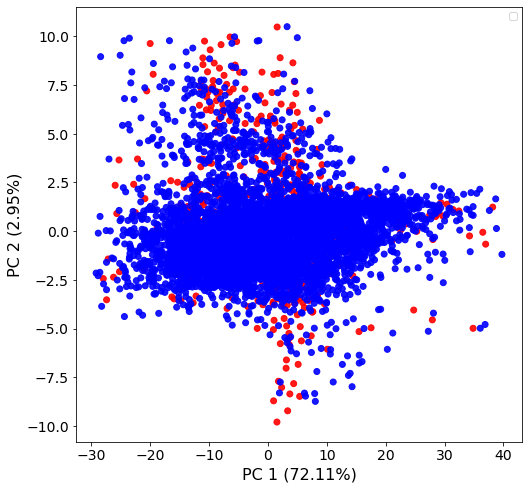

In [15]:
plt.figure(figsize=(8,8))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(pca_result[:,0], pca_result[:,1], c=cvec, alpha=0.9)
plt.legend()
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100), fontsize=16);
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100), fontsize=16);

## T-Distributed Stochastic Neighbouring Entities (t-SNE) Plot

In [16]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5756 samples in 0.000s...
[t-SNE] Computed neighbors for 5756 samples in 1.304s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5756
[t-SNE] Computed conditional probabilities for sample 2000 / 5756
[t-SNE] Computed conditional probabilities for sample 3000 / 5756
[t-SNE] Computed conditional probabilities for sample 4000 / 5756
[t-SNE] Computed conditional probabilities for sample 5000 / 5756
[t-SNE] Computed conditional probabilities for sample 5756 / 5756
[t-SNE] Mean sigma: 2.507176
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.617210
[t-SNE] KL divergence after 300 iterations: 2.343940
t-SNE done! Time elapsed: 4.680448532104492 seconds


Text(0, 0.5, 'tsne-2d-two')

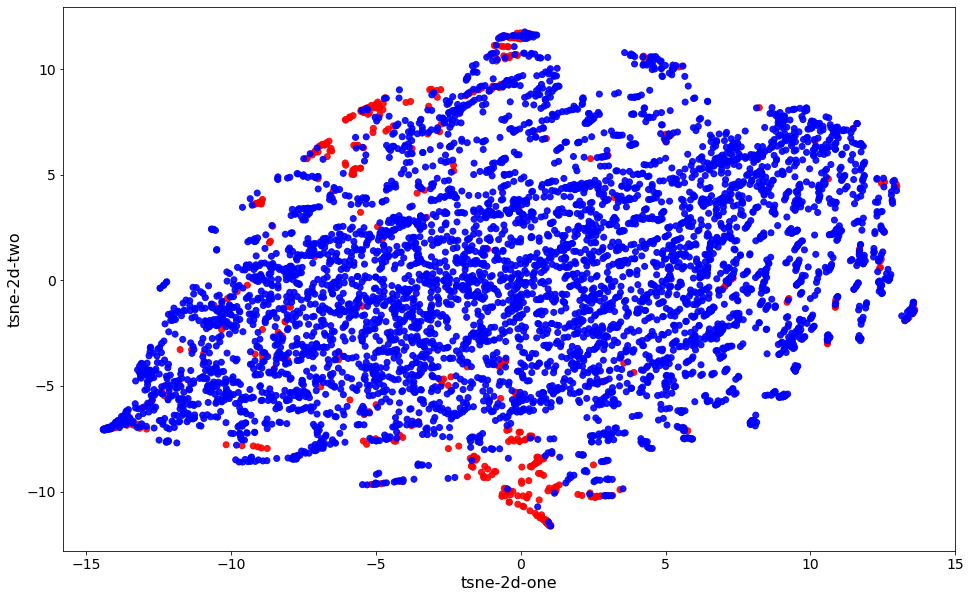

In [17]:
plt.figure(figsize=(16,10))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cvec, alpha=0.9)
plt.xlabel('tsne-2d-one', fontsize=16)
plt.ylabel('tsne-2d-two', fontsize=16) 

# Random forest
Here, we train a random forest model using all available training data

In [18]:
label_1 = np.ones(diff_vectors_pos.shape[0])
label_0 = np.zeros(diff_vectors_neg.shape[0])
y_train = np.concatenate((label_1,label_0))
print("Total training labels: %d" % len(y_train))

Total training labels: 5756


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

n_estimators = [100, 200, 300, 400, 500]
max_features = ['auto', 'sqrt']
max_depth = [10, 20, 30, 40, 50, None]
min_samples_split = [2, 3, 5, 7, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1, cv = 10, random_state=42)

rf_random.fit(X_train,y_train)

best_model = rf_random.best_estimator_

In [20]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

# Prediction
This step creates a list of all possible combinations of protein kinases and cancers in the variable ``diff_vectors_prediction``. 
This step typically takes several hours. In the following, we use the Random Forest model to predict the probabilities of each
protein kinase-cancer pair of representing a valid therapeutic opportunity.

In [21]:
pickle_path = "prediction-vectors.pkl"
if os.path.isfile(pickle_path):
    print("loading prediction vectors from file")
    with open(pickle_path, "rb") as fpred:
         diff_vectors_prediction = pickle.load(fpred)
else:
    print("creating difference vectors (this step can take several hours)")
    diff_vectors_prediction = dsGen.get_disease_kinase_difference_vectors(prediction_df)
    print("storing difference vectors to file")
    diff_vectors_prediction.to_pickle(pickle_path)

loading prediction vectors from file


## Classification results
The ``KcetParser`` class has methods that take the labels of the difference vectors used for classification (e.g.,  ``ncbigene5599-meshd000074723``) and show the corresponding gene symbols and MeSH labels (neoplasms) as well as the Random Forest predictions.

The ``deleteEmbeddings`` argument determines whether we only return the
three columns ``gene_symbol1``, ``cancer``, and ``probability``.

In [22]:
y_pred = best_model.predict(diff_vectors_prediction)
yproba = best_model.predict_proba(diff_vectors_prediction)[::,1]

from kcet import KcetParser
kcetParser = KcetParser()
predictions = kcetParser.decode_predictions(vectors=diff_vectors_prediction, probabilities=yproba, deleteEmbeddings=True)
predictions.head(n=20)

[INFO] Reading protein kinase information from /home/peter/GIT/KCET/input/prot_kinase.tsv
[INFO] ingested symbol_to_id_map with 522 entries such as {'NCBIGene:2870': 'GRK6'}
[INFO] Ingested mesh_id list with 698 entries such as 'meshd000008' and 'meshd000069293', 
[INFO] Ingested _meshid2disease_map with 698 entries
[INFO] Ingested meshid2disease_map with 514 entries
[INFO] Ingested pki_to_kinase with 76 entries


,gene_symbol,cancer,probability
ncbigene57172-meshd002289,CAMK1G,"Carcinoma, Non-Small-Cell Lung",0.890000
ncbigene22858-meshd008175,CILK1,Lung Neoplasms,0.885000
ncbigene2260-meshd009362,FGFR1,Neoplasm Metastasis,0.880000
ncbigene269-meshd008175,AMHR2,Lung Neoplasms,0.880000
ncbigene2043-meshd007938,EPHA4,Leukemia,0.879951
ncbigene2048-meshd007938,EPHB2,Leukemia,0.875674
ncbigene283629-meshd002289,TSSK4,"Carcinoma, Non-Small-Cell Lung",0.870000
ncbigene2261-meshd009362,FGFR3,Neoplasm Metastasis,0.865000
ncbigene23617-meshd002289,TSSK2,"Carcinoma, Non-Small-Cell Lung",0.865000
ncbigene57538-meshd002289,ALPK3,"Carcinoma, Non-Small-Cell Lung",0.855000


In [23]:
print("Total number of predictions:", len(predictions))

Total number of predictions: 330922


## Optimal Threshold

In [30]:
y_prd = best_model.predict(X_train)

In [31]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train,y_prd)

In [36]:
from numpy import sqrt,argmax
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
opt_thres = thresholds[ix]
print('Best threshold=%f, G-Mean=%.3f' % (opt_thres, gmeans[ix]))

Best threshold=1.000000, G-Mean=1.000


# Save novel predictions to file.
The following command saves the predictions to a file called ``predictions_novel.tsv``.

In [25]:
predictions.to_csv("predictions_novel.tsv",index=False,sep="\t")

## Visualizing positive and negative examples
Here, we plot the distributions of the probabiliies of the positive and negative training samples as calculated by the random forest.

In [39]:
y_pred_train = best_model.predict(X_train)
yproba_train = best_model.predict_proba(X_train)[::,1]

In [40]:
n_pos_train= len(diff_vectors_pos)
n_neg_train = len(diff_vectors_neg)
pos_train_probs = yproba_train[:n_pos_train]
neg_train_probs = yproba_train[n_pos_train:]
print("[INFO] Got %d positive and %d negative predictions" % (len(pos_train_probs), len(neg_train_probs)))

[INFO] Got 559 positive and 5197 negative predictions


In [41]:
posnp = np.array(pos_train_probs)
pos_train = pd.Series(posnp, name="Prediction score of positive training")
negnp = np.array(neg_train_probs)
neg_train = pd.Series(negnp, name="Prediction score of negative training")

In [42]:
probability = predictions['probability'].tolist()
prediction_scores = np.array(probability)
prediction = pd.Series(prediction_scores, name="Prediction score")

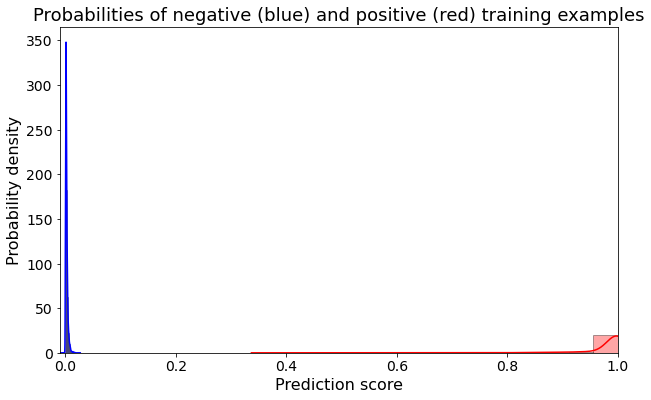

In [43]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(111)

pos_train.plot.kde(ax=ax1, legend=False,color ="red")
pos_train.plot.hist(density = True, ax=ax1, color="red", edgecolor="black", alpha = 0.35)
neg_train.plot.kde(ax=ax1, legend=False,color ="blue")
neg_train.plot.hist(density=True, ax=ax1, color="blue", edgecolor="black", alpha = 0.35)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([-0.01, 1.0])
plt.title("Probabilities of negative (blue) and positive (red) training examples", fontsize=18)
ax1.set_xlabel("Prediction score", fontsize=16);
ax1.set_ylabel('Probability density', fontsize=16);
#fig.savefig("neg-and-pos-examples.pdf")

# Distribution of predictions

The vast majority of the protein-kinase-cancer pairs receive a low prediction score.

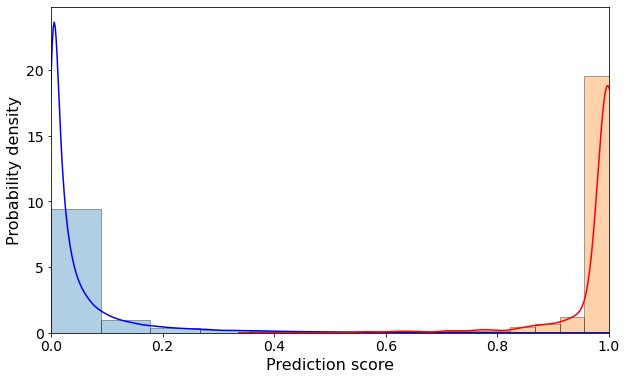

In [44]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

prediction.plot.kde(ax=ax, legend=False,color ="blue")
prediction.plot.hist(density=True, ax=ax, edgecolor="black", alpha = 0.35)

pos_train.plot.kde(ax=ax, legend=False,color ="red")
pos_train.plot.hist( density = True, ax=ax, edgecolor="black", alpha = 0.35)

plt.xlim([0.0, 1.0])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xlabel("Prediction score", fontsize=16);
ax.set_ylabel('Probability density', fontsize=16);
#fig.savefig("pos-vs-new-predictions.pdf")

Here we show the predictions for negative training, positive training, and de novo predictions (i.e., everything else)

In [45]:
data = []
data.append({'level': 'min', 'pos': np.min(posnp), 'neg': np.min(negnp), 'pred': np.min(prediction_scores)})
for i in [1, 5, 10, 20, 80, 90, 95, 99, 99.5, 99.9, 99.99]:
    data.append({'level': 'percentile: %.2f'%i, 'pos': np.percentile(posnp, i), 'neg': np.percentile(negnp, i), 'pred': np.percentile(prediction_scores, i)})
data.append({'level': 'max', 'pos': np.max(posnp), 'neg': np.max(negnp), 'pred': np.max(prediction_scores)})
df = pd.DataFrame(data)
df.head(20)

,level,pos,neg,pred
0,min,0.558002,0.000000,0.000000
1,percentile: 1.00,0.656433,0.000027,0.000687
2,percentile: 5.00,0.863090,0.000316,0.001101
3,percentile: 10.00,0.934032,0.000650,0.001395
4,percentile: 20.00,0.985475,0.001056,0.002428
5,percentile: 80.00,1.000000,0.003494,0.068821
6,percentile: 90.00,1.000000,0.004731,0.140601
7,percentile: 95.00,1.000000,0.006226,0.237533
8,percentile: 99.00,1.000000,0.009437,0.474939
9,percentile: 99.50,1.000000,0.011337,0.570068


# Output interesting predictions

We chose a threshold of 0.556 (as described in the manuscript) for calling a prediction 'positive'. Here we output the predictions to file for downstream analysis.

In [46]:
threshold = 0.556 # we set this threshold according to the figure that illustrates the prob. density of pos. training and neg. training
predictions_above_threshold = predictions.loc[predictions["probability"]>= threshold]
predictions_above_threshold.head()

,gene_symbol,cancer,probability
ncbigene57172-meshd002289,CAMK1G,"Carcinoma, Non-Small-Cell Lung",0.890000
ncbigene22858-meshd008175,CILK1,Lung Neoplasms,0.885000
ncbigene2260-meshd009362,FGFR1,Neoplasm Metastasis,0.880000
ncbigene269-meshd008175,AMHR2,Lung Neoplasms,0.880000
ncbigene2043-meshd007938,EPHA4,Leukemia,0.879951


In [47]:
print("Number of predictions with estimated probability above {}: {}".format(threshold, len(predictions_above_threshold)))

Number of predictions with estimated probability above 0.556: 1809


In [48]:
predictions_above_threshold.to_csv("novel_predicions_score_above_{}.tsv".format(threshold),index=False,sep="\t")